# **Part 1 - Backprop**


Best hyperparams found for highest validation acc at the end of 10 epochs:

With RELU nonlinearity:

Learning rate :0.1

hidden layer sizes 512, 1024

batch_size: 200

These parameters are also going to be the 'fixed setting' that we use in the questions regarding initialisation and there onwards.


Gradient Computation:
We can derive the gradient wrt. softmax with cross entropy loss as:

(predictions-y) 

where y is the one hot encoding of ground truth labels and predictions is the vector containing the softmax outputs.
Gradients for weights and biases of layers are computed as per chain rule.

At the end of 10 epochs a validation accuracy of 97.2% is reached with the above hyperparams and settings.



In [0]:
import numpy as np
import random
from matplotlib import pyplot as plt
import math

class NN(object):
    
    def __init__(self,hidden_dims=(512,1024),n_hidden=2,mode='train', \
                 initmethod = 'glorot', epochs=10, lr=0.1, batch_size=200):
        self.init_method = initmethod
        
        self.h0 = 784     
        self.h1 = hidden_dims[0]
        self.h2 = hidden_dims[1]
        self.h3 = 10
        
        self.layer_sizes = [self.h0, self.h1, self.h2, self.h3]
        self.network = [] # list of weights
        self.num_hlayers = 2
        self.num_classes = 10
        
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        
        self.dataprep()
        if(mode=='train'):
            self.initialize_weights()
            loss, val_loss = self.train()
            self.plot(loss, val_loss)

        

    def dataprep(self):

        data = np.load('mnist.pkl.npy', encoding='latin1')
      
        train_set = data[0][0]
        self.val_set = data[1][0]
        self.test_set = data[2][0]
        
        
        self.val_labels = data[1][1]
        self.test_labels = data[2][1]

        self.train_size = train_set.shape[0]
        self.val_size = self.val_set.shape[0]
        self.test_size = self.test_set.shape[0]

        p = np.random.permutation(self.train_size)
        self.train_set = train_set[p]
        self.train_labels = data[0][1][p]

        print(self.train_set.shape)
        print(self.val_set.shape)
        print(self.test_set.shape)
    
    def plot(self, loss, val_loss):
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
      
    def train(self):    
        m = self.train_size
        val_samples = self.val_size

        loss_history = np.zeros(self.epochs)
        val_loss_history = np.zeros(self.epochs)
        n_batches = int(m/self.batch_size)
        batch_size = self.batch_size

        
        
        print('zero shot validation')
        val_batches = 0
        val_loss= 0.0
        val_accuracy = 0
        for i in range(0,val_samples-batch_size+1,batch_size):
            X_i_val = self.val_set[i:i+batch_size]
            y_i_val = self.val_labels[i:i+batch_size]
            outputs_val = self.forward(X_i_val)
            
            labels = np.argmax(outputs_val[-1], axis=1)
            val_accuracy += (y_i_val == labels).sum()           
            
            one_hot = np.zeros((self.batch_size, self.num_classes))
            one_hot[np.arange(self.batch_size), y_i_val] = 1
            loss_val_batch = self.loss(outputs_val[-1], one_hot)
            val_loss += loss_val_batch
            val_batches +=1
        val_accuracy = val_accuracy/(1.0*val_batches*self.batch_size)
        val_loss = val_loss/(1.0*val_batches*self.batch_size)
        print('val accuracy : '+str(val_accuracy) + \
              '       val loss : ' + str(val_loss))
            
            
        
        for it in range(self.epochs):
            print('epoch : '+str(it))
            loss = 0.0
            val_loss= 0.0
            train_accuracy = 0
            indices = np.random.permutation(m)
            train_set = self.train_set[indices]
            train_labels = self.train_labels[indices]


            train_batches = 0 
            for i in range(0,m-batch_size+1,batch_size):
                X_i = train_set[i:i+batch_size]
                y_i = train_labels[i:i+batch_size]
                outputs = self.forward(X_i)
                loss_batch, accuracy_batch = self.backward(y_i)
                loss += loss_batch
                train_accuracy += accuracy_batch
                train_batches +=1
            loss = loss/(1.0*train_batches*self.batch_size)
            train_accuracy = train_accuracy/(1.0*train_batches*self.batch_size)

            print('train accuracy : ' + str(train_accuracy) + \
                  '     train loss : '+ str(loss))

            val_batches = 0
            val_accuracy = 0
            for i in range(0,val_samples-batch_size+1,batch_size):
           
        
                X_i_val = self.val_set[i:i+batch_size]
                y_i_val = self.val_labels[i:i+batch_size]
                outputs_val = self.forward(X_i_val)
                labels = np.argmax(outputs_val[-1], axis=1)
                val_accuracy += (y_i_val == labels).sum()  
            
                one_hot = np.zeros((self.batch_size, self.num_classes))
                one_hot[np.arange(self.batch_size), y_i_val] = 1
                                
                loss_val_batch = self.loss(outputs_val[-1], one_hot)
                val_loss += loss_val_batch
                val_batches +=1
            val_loss = val_loss/(1.0*val_batches*self.batch_size)
            val_accuracy = val_accuracy/(1.0*val_batches*self.batch_size)
            print('val accuracy : '+str(val_accuracy) + \
                  '      val loss : ' + str(val_loss))


            val_loss_history[it]  = val_loss
            loss_history[it]  = loss

        return loss_history, val_loss_history

    def initialize_weights(self):
        if(self.init_method=='zeros'):
            for i in range(len(self.layer_sizes)-1):
                layer_weights = np.zeros((self.layer_sizes[i]+1,\
                                          self.layer_sizes[i+1]))
                layer_weights[-1,:] = 0
                print(layer_weights.shape)
                self.network.append(layer_weights) 
        elif(self.init_method=='glorot'):

            for i in range(len(self.layer_sizes)-1):
                d = math.sqrt(6.0/(self.layer_sizes[i]+self.layer_sizes[i+1]))      
                layer_weights = np.random.uniform(-d,d,\
                                    (self.layer_sizes[i]+1,self.layer_sizes[i+1]))
                layer_weights[-1,:] = 0
                print(layer_weights.shape)
                self.network.append(layer_weights)    
                
        else:
            for i in range(len(self.layer_sizes)-1):
                layer_weights = np.random.randn(self.layer_sizes[i]+1,\
                                                self.layer_sizes[i+1])
                layer_weights[-1,:] = 0  
                print(layer_weights.shape)
                self.network.append(layer_weights) 

  
    def activation(self,inputs, layer_no):
        inputs = np.hstack((inputs, np.ones((inputs.shape[0],1)) ))
        activation = np.dot(inputs, self.network[layer_no])     
        return activation
    
    def softmax(self,inputs): 
        # Result of softmax are invariant even if we add/subtract a constant.  
        ex = np.exp(inputs - np.max(inputs, axis=1,  keepdims=True))  
        # Subtract such that the maximum value is one.

        return ex/np.sum(ex, axis=1,  keepdims=True)
      
    def stable_softmax(self,inputs): 
        # Result of softmax are invariant even if we add/subtract a constant.  
        max_inputs = np.max(inputs, axis=1,  keepdims=True)
        ex = np.exp(inputs - max_inputs)                          
        # Subtract such that the maximum value is one.
        logsumexp = np.log(np.sum(ex, axis=1, keepdims=True)) + max_inputs
        return np.exp(inputs - logsumexp),inputs - logsumexp                 

    def forward(self,inputs):

        #we are always appending inputs before doing relu to the cache
        self.layer_outputs = []
        self.layer_outputs.append(inputs)

        for layer_no in range(len(self.network)-1):        
            inputs = self.activation(inputs, layer_no)

            self.layer_outputs.append(inputs)
            np.maximum(inputs,0,inputs)              #relu     
       
        inputs = self.activation(inputs, len(self.network)-1 )

        inputs, stable_inputs = self.stable_softmax(inputs)
        self.layer_outputs.append(inputs)
        return self.layer_outputs 
      
    def relu(self, inputs):
        outputs = np.maximum(inputs,0)
        return outputs
      
    def backward(self, labels, getGrads=False):

        self.grad_L_wrt_Ws = []

        softmax_output = self.layer_outputs[-1]

        one_hot = np.zeros((self.batch_size, self.num_classes))

        one_hot[np.arange(self.batch_size), labels] = 1

        # Loss, accuracy

        loss_batch = self.loss(softmax_output, one_hot)

        pred_labels = np.argmax(softmax_output, axis=1)

        accuracy_batch = (labels == pred_labels).sum()

        # Derivative of loss wrt softmax_input

        # = softmax_out[d] when target[d] = 0, = softmax_out[d] - 1 when target[d] = 1

        grad_L_wrt_softmax_input = softmax_output - one_hot

        # softmax_in = layer3_output = W_h2_h3*layer3_input 
        #= W_h2_h3*relu(layer2_output)

        # grad_L_wrt_W_h2_h3 
        #= (grad_L_wrt_layer3_output)*(grad_layer3_output_wrt_W_h2_h3)

        # 2nd term grad_layer3_output_wrt_W_h2_h3 = layer3_input = max(layer2_output, 0)

        grad_L_wrt_layer_out = grad_L_wrt_softmax_input

        for layer_neg_idx in range(-1, -len(self.network)-1, -1):

            # print("backward", layer_neg_idx)

            prev_layer_output = self.layer_outputs[layer_neg_idx-1]

            layer_input = self.relu(np.hstack(( prev_layer_output,\
                                               np.ones((self.batch_size, 1)) )) )

            grad_L_wrt_W = np.matmul(layer_input.T, grad_L_wrt_layer_out)

            self.grad_L_wrt_Ws.append(grad_L_wrt_W/self.batch_size)

            # For prev layer

            # grad_L_wrt_layer2_output
            
            #   = (grad_L_wrt_layer3_output)*(grad_layer3_output_wrt_layer2_output)

            #   = (grad_L_wrt_layer3_output)*(grad_(W*relu(layer2_output))_wrt_layer2_output)

            #   = (grad_L_wrt_layer3_output)*W*(grad_(relu(layer2_output))_wrt_layer2_output)

            #   = (grad_L_wrt_layer3_output)*W*(layer2_output > 0)

            grad_L_wrt_prev_layer_out = np.matmul(grad_L_wrt_layer_out,\
                self.network[layer_neg_idx][:-1, :].T) * (prev_layer_output > 0).astype('float')

            grad_L_wrt_layer_out = grad_L_wrt_prev_layer_out

        if(not getGrads):
            self.update(self.grad_L_wrt_Ws)
            return loss_batch, accuracy_batch
        else:
            return loss_batch, accuracy_batch, self.grad_L_wrt_Ws

          
    def reluDerivative(x): 
        x[x<=0] = 0
        x[x>0] = 1
        return x
        
        
    def loss(self,predictions,targets): #cross entropy

        epsilon = 1e-12
        predictions = np.clip(predictions, epsilon, 1. - epsilon)
        ce = -np.sum(np.multiply(targets,np.log(predictions+1e-9)), axis=1)

        ce = np.sum(ce)
        return ce
    
    def update(self,grads):
        length_net = len(self.network)
        assert(len(grads)==length_net)

        i=0
        for layer_no in range(length_net):
            self.network[layer_no] -= self.lr * grads[length_net-1-i]             
            i += 1
            
    def test(self):
        m = self.test_size
        batch_size = self.batch_size

        for it in range(self.epochs):
            loss =0.0
            test_batches = 0
            test_accuracy = 0
            for i in range(0,m-batch_size,batch_size):
                X_i = self.test_set[i:i+batch_size]
                y_i = self.test_labels[i:i+batch_size]
                outputs = self.forward(X_i)  
                one_hot = np.zeros((self.batch_size, self.num_classes))
                one_hot[np.arange(self.batch_size), y_i] = 1                
                loss += self.loss(outputs[-1], one_hot)
                test_batches +=1
                labels = np.argmax(outputs[-1], axis=1)
                test_accuracy += (y_i == labels).sum() 
        test_loss = loss/(1.0*test_batches*self.batch_size)
        test_accuracy = test_accuracy/(1.0*test_batches*self.batch_size)
        print('test loss : ' + str(test_loss) + \
              '          test accuracy : '+ str(test_accuracy))            
      
    def grad_check(self):
        self.batch_size=1
        l=6
        X_i_val = self.val_set[l:l+self.batch_size]
        y_i_val = self.val_labels[l:l+self.batch_size]
        outputs_val = self.forward(X_i_val)
        loss_batch, accuracy_batch, gradients = self.backward(y_i_val, getGrads= True)

        diffs=[]
        for n in range(1,6):
            for m in [1,5]:
                numerical, computed = self.finite_diff(gradients, n, X_i_val, y_i_val, m)
                diffs.append(max(numerical-computed))
        plt.plot(diffs)
        plt.show()
            
    def finite_diff(self, gradients, n, inputs, labels, m):
        targets = np.zeros((self.batch_size, self.num_classes))
        targets[np.arange(self.batch_size), labels] = 1
        epsilon = 1/(m*1.0*(10**n))
        print('epsilon:'+str(epsilon))
        length_net = len(self.network)
        layer_no = 1
        layer_grad = []
        i=0
        for j in range(10):
          
            self.network[layer_no][i,j] = self.network[layer_no][i,j] + epsilon
            output_p =self.loss(self.forward(inputs)[-1], targets)
            self.network[layer_no][i,j] = self.network[layer_no][i,j] - 2*epsilon

            output_n = self.loss(self.forward(inputs)[-1], targets)

            self.network[layer_no][i,j] = self.network[layer_no][i,j] + epsilon
            grad = (output_p - output_n)/(2*epsilon)
   
            layer_grad.append(grad)
            
        compare_grad = gradients[length_net-2][0][:10]
        return np.array(layer_grad), compare_grad

   

# Run neural net training and testing to see final loss curves after 10 epochs

(50000, 784)
(10000, 784)
(10000, 784)
(785, 700)
(701, 512)
(513, 10)
zero shot validation
val accuracy : 0.1224       val loss : 2.3177577554446294
epoch : 0
train accuracy : 0.8981     train loss : 0.36324488319177406
val accuracy : 0.937      val loss : 0.20939831820010887
epoch : 1
train accuracy : 0.95078     train loss : 0.1655519366089717
val accuracy : 0.9632      val loss : 0.13019896749798598
epoch : 2
train accuracy : 0.96608     train loss : 0.11469119600135884
val accuracy : 0.9713      val loss : 0.10111679563388112
epoch : 3
train accuracy : 0.97472     train loss : 0.08732825579168026
val accuracy : 0.9715      val loss : 0.09925817380184349
epoch : 4
train accuracy : 0.98058     train loss : 0.06812781888104029
val accuracy : 0.9759      val loss : 0.08379519445283257
epoch : 5
train accuracy : 0.98454     train loss : 0.05446491581376415
val accuracy : 0.9769      val loss : 0.08114256388627394
epoch : 6
train accuracy : 0.98746     train loss : 0.04421509691597075
v

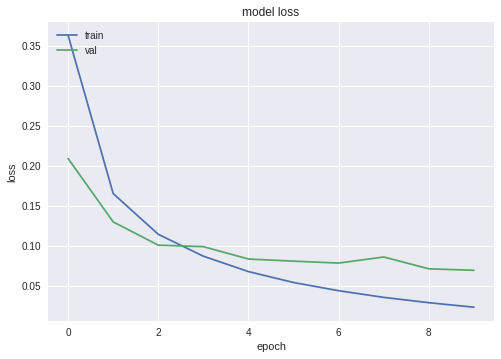

In [36]:
nn = NN()

In [21]:
nn.test()

test loss : 0.2125267076205614          test accuracy : 0.9391939193919392


2125.0545494979933

# Trying different weight initialisations

////////////////glorot initialisation///////////////////////
(50000, 784)
(10000, 784)
(10000, 784)
(785, 512)
(513, 1024)
(1025, 10)
zero shot validation
val accuracy : 0.0819       val loss : 2.326009628031885
epoch : 0
train accuracy : 0.85578     train loss : 0.542020822468647
val accuracy : 0.9221      val loss : 0.26892395860852314
epoch : 1
train accuracy : 0.92466     train loss : 0.25971223105351704
val accuracy : 0.9389      val loss : 0.20602739685663674
epoch : 2
train accuracy : 0.94146     train loss : 0.20090755575504918
val accuracy : 0.9544      val loss : 0.17003026526937148
epoch : 3
train accuracy : 0.95158     train loss : 0.16600109674121463
val accuracy : 0.961      val loss : 0.14593449397780878
epoch : 4
train accuracy : 0.9596     train loss : 0.14008405793603723
val accuracy : 0.9649      val loss : 0.13401200857194148
epoch : 5
train accuracy : 0.96526     train loss : 0.12041383640381353
val accuracy : 0.9648      val loss : 0.12810445818959257
epoch : 6
tr

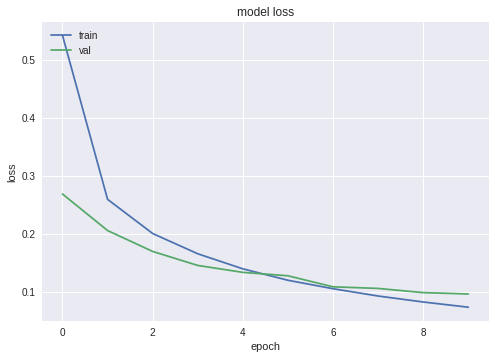

In [54]:
print('////////////////glorot initialisation///////////////////////')
nn_glorot = NN(initmethod= 'glorot')



////////////////zeros initialisation///////////////////////
(50000, 784)
(10000, 784)
(10000, 784)
(785, 512)
(513, 1024)
(1025, 10)
zero shot validation
val accuracy : 0.0991       val loss : 2.302585082994046
epoch : 0
train accuracy : 0.11294     train loss : 2.3022687921666756
val accuracy : 0.1064      val loss : 2.3021843951713272
epoch : 1
train accuracy : 0.11356     train loss : 2.301777791376592
val accuracy : 0.1064      val loss : 2.301982066276648
epoch : 2
train accuracy : 0.11356     train loss : 2.3014790425272116
val accuracy : 0.1064      val loss : 2.301889863904215
epoch : 3
train accuracy : 0.11356     train loss : 2.301301302981305
val accuracy : 0.1064      val loss : 2.301854067208434
epoch : 4
train accuracy : 0.11356     train loss : 2.301192814163037
val accuracy : 0.1064      val loss : 2.3018503042713427
epoch : 5
train accuracy : 0.11356     train loss : 2.301129920081543
val accuracy : 0.1064      val loss : 2.301863708527277
epoch : 6
train accuracy : 0.

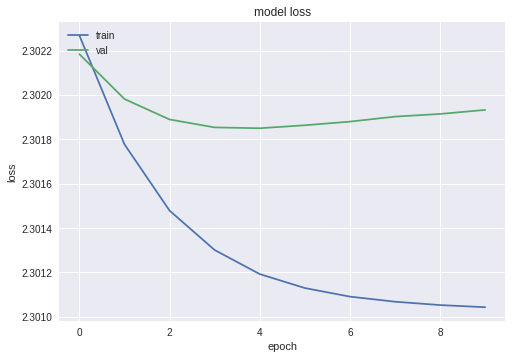

In [51]:
print('////////////////zeros initialisation///////////////////////')
nn_zero = NN(initmethod= 'zeros')

////////////////gaussian initialisation///////////////////////
(50000, 784)
(10000, 784)
(10000, 784)
(785, 512)
(513, 1024)
(1025, 10)
zero shot validation
val accuracy : 0.1011       val loss : 18.627245209883068
epoch : 0
train accuracy : 0.8445     train loss : 3.1878481668288594
val accuracy : 0.9118      val loss : 1.8031152140938593
epoch : 1
train accuracy : 0.92512     train loss : 1.5222325269595003
val accuracy : 0.9259      val loss : 1.5073912996726935
epoch : 2
train accuracy : 0.94582     train loss : 1.0982559328256152
val accuracy : 0.9313      val loss : 1.397139344269522
epoch : 3
train accuracy : 0.9584     train loss : 0.835523906152143
val accuracy : 0.9326      val loss : 1.3650735630875819
epoch : 4
train accuracy : 0.96786     train loss : 0.6400965133504405
val accuracy : 0.9364      val loss : 1.2903830512495573
epoch : 5
train accuracy : 0.97472     train loss : 0.4964545655733264
val accuracy : 0.9374      val loss : 1.2834142365579424
epoch : 6
train accur

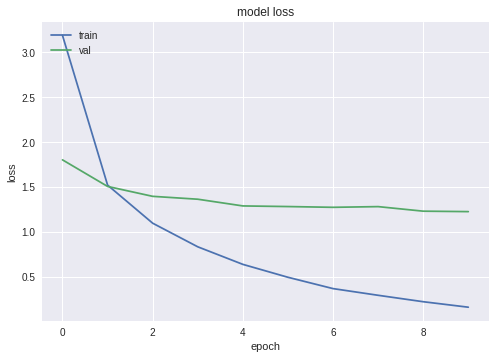

In [50]:
print('////////////////gaussian initialisation///////////////////////')
nn_gaussian = NN(initmethod= '', lr=0.01)

Conclusion:
we see that with zeros as the weight init, as expected, no learning happens since backprop can't compute any useful gradients to propagate since the gradient for a weight that is zero will be zero.
We see better performance, and more importantly faster convergence for the glorot initialisation.
The gaussian weights give good performance too, but reach a lower final accuracy and take longer to converge to this accuracy. They also don't generalise as well as the case of the glorot init.



# Best hyperparam search

-varied batch size, learning rate, hidden layer sizes and number of epochs


batch size : a,b,c -> 10, 80, 200

epochs : d,e -> 10, 50

Learning rate: g,h,i -> 0.1,  0.01,  0.001

Hidden layer config: j,k -> (512,1024), (700,512) 

The following indicates the setup along with the validation accuracy.

- adgk  -> 98.12

- bdgk  -> 97.97

- bdgj  -> 98.19%

- cdgj  -> 97.2%

- cdhj  -> 92%

- cdik  -> 84%

- cegj  -> 98.12%


## Run finite diff code and plot how the max difference betwen backprop-computed gradients and numerical gradients changes as we increase the value of N/decrease epsilon.

(50000, 784)
(10000, 784)
(10000, 784)
(785, 512)
(513, 1024)
(1025, 10)
zero shot validation
val accuracy : 0.1025       val loss : 2.341138418133865
epoch : 0
train accuracy : 0.8592     train loss : 0.535765870846202
val accuracy : 0.9224      val loss : 0.27096104212662897
epoch : 1
train accuracy : 0.92738     train loss : 0.2530637168297488
val accuracy : 0.9443      val loss : 0.20704507578480175


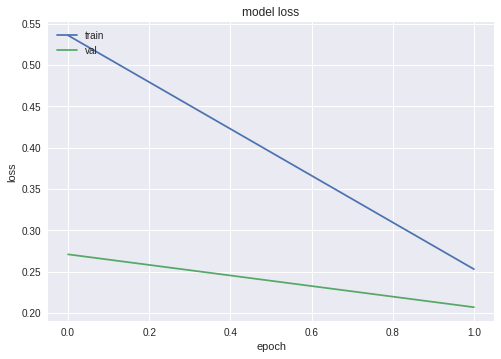

epsilon:0.1
epsilon:0.02
epsilon:0.01
epsilon:0.002
epsilon:0.001
epsilon:0.0002
epsilon:0.0001
epsilon:2e-05
epsilon:1e-05
epsilon:2e-06


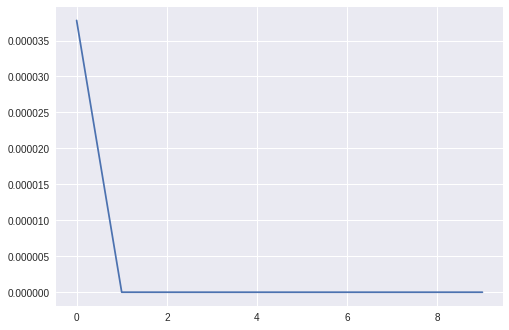

In [55]:
nn = NN(epochs=2)
nn.grad_check()

The plot above shows that the difference tends to 0 as we increase N/decrease epsilon,this is to be expected because the numerical gradient should approach the true gradient(from backprop) as epsilon becomes smaller.